In [1]:
%matplotlib inline


import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat

import glob

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Load in GEOS Chem Runs

Using egrid, NEI, and our model emissions inventories for NO, NO2, SO2

In [2]:
ds_egrid_speciesconc = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation-egrid/OutputDir/GEOSChem.SpeciesConc.201508*.nc4')
ds_egrid_aerosolmass = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation-egrid/OutputDir/GEOSChem.AerosolMass.201508*.nc4')
ds_egrid = xr.merge([ds_egrid_aerosolmass, ds_egrid_speciesconc])
ds_egrid.attrs['name'] = 'egrid'

ds_NEI_speciesconc = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gtropchem/merra2_05x0625_tropchem_na/OutputDir/GEOSChem.SpeciesConc.201508*.nc4')
ds_NEI_aerosolmass = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gtropchem/merra2_05x0625_tropchem_na/OutputDir/GEOSChem.AerosolMass.201608*.nc4')
ds_NEI = xr.merge([ds_NEI_aerosolmass, ds_NEI_speciesconc])
ds_NEI.attrs['name'] = 'NEI'

ds_MODEL_speciesconc = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/OutputDir/GEOSChem.SpeciesConc.201508*_0000z.nc4')
ds_MODEL_aerosolmass = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/OutputDir/GEOSChem.AerosolMass.201508*_0000z.nc4')
ds_MODEL = xr.merge([ds_MODEL_aerosolmass, ds_MODEL_speciesconc])
ds_MODEL.attrs['name'] = 'MODEL'

ds_nonuc_speciesconc = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_nonuclear/OutputDir/GEOSChem.SpeciesConc.201508*_0000z.nc4')
ds_nonuc_aerosolmass = xr.open_mfdataset('../../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_nonuclear/OutputDir/GEOSChem.AerosolMass.201508*_0000z.nc4')
ds_nonuc = xr.merge([ds_nonuc_aerosolmass, ds_nonuc_speciesconc])
ds_nonuc.attrs['name'] = 'nonuc'

datasets = [
    ds_NEI,
    ds_egrid,
    ds_MODEL,
    ds_nonuc
]

In [3]:
######### calculate NOx in our datasets #######
for d in datasets:
    d['SpeciesConc_NOx'] = (
        d['SpeciesConc_NO'] + d['SpeciesConc_NO2'] #sum our NO2 and NO to get NOx
                    ) 

######### put into one dataset and convert to ppbv ###########
ds=xr.Dataset() #create an empty dataset
conc_species = [ #create a list of the species we got from our species conc
    'NO',
    'NO2',
    'NOx',
    'SO2',
    'O3'
]

for d in datasets:
    for s in conc_species: #add all species to our dataset
        dname = d.attrs['name']
        ds[f'{dname}_{s}'] = d[f'SpeciesConc_{s}'] *1e9 #convert from mol/mol to ppbv
        ds[f'{dname}_{s}'].attrs['units'] = 'ppbv'
    ds[f'{dname}_PM25'] = d['PM25']
    ds[f'{dname}_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
    
for s in conc_species:#calculate the differences
        ds[f'dif_{s}'] = ds[f'MODEL_{s}']- ds[f'nonuc_{s}'] 
        ds[f'dif_{s}'].attrs['units'] = 'ppbv'
ds['dif_PM25'] = ds['MODEL_PM25'] - ds['nonuc_PM25']
ds[f'dif_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'

ds = ds.isel(lev = 0) #select surface level of data only
ds #print the dataset

<xarray.Dataset>
Dimensions:     (lat: 121, lon: 161, time: 62)
Coordinates:
  * time        (time) datetime64[ns] 2015-08-01T12:00:00 ... 2016-08-31T12:00:00
    lev         float64 0.9925
  * lat         (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 68.5 69.0 69.5 70.0
  * lon         (lon) float64 -140.0 -139.4 -138.8 ... -41.25 -40.62 -40.0
Data variables:
    NEI_NO      (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_NO2     (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_NOx     (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_SO2     (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_O3      (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_PM25    (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(32, 121, 161)>
    egrid_NO    (time, lat, lon) float32 dask

### Load in EPA Observational data
data is from https://aqs.epa.gov/aqsweb/airdata/download_files.html
for the year 2016
choosing O3, NO, SO2, PM25 (FEM/FRM)


In [4]:
EPA_obs_df = pd.concat(map(pd.read_csv, glob.glob('../../../GEOS_CHEM/obs_data/daily*.csv')))
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['Date Local'])

In [5]:
lat_obs = EPA_obs_df['Latitude'].unique()
lon_obs = EPA_obs_df['Longitude'].unique()
time = EPA_obs_df['date'].unique()

In [6]:
#change index
EPA_obs_df = EPA_obs_df.set_index(['Longitude','Latitude','Parameter Name','date'])
#take only one reading from each location on each date for each pollutant (series)
EPA_obs_df = EPA_obs_df['Arithmetic Mean'].groupby(EPA_obs_df.index).first()
#create a new index (it was lost above) and rename our axes
EPA_obs_df.index = pd.MultiIndex.from_arrays([EPA_obs_df.index.str[2],EPA_obs_df.index.str[3], EPA_obs_df.index.str[1],EPA_obs_df.index.str[0]])
EPA_obs_df = EPA_obs_df.rename_axis(('species','time', "lat","lon"))
#convert our series back to a dataframe
EPA_obs_df = EPA_obs_df.to_frame()


In [7]:
EPA_obs_df.head()

Arithmetic Mean
species                time       lat       lon                        
Nitrogen dioxide (NO2) 2016-03-18 21.949599 -159.36624         1.366667
                       2016-03-19 21.949599 -159.36624         0.862500
                       2016-03-20 21.949599 -159.36624         3.858333
                       2016-03-21 21.949599 -159.36624         1.129167
                       2016-03-22 21.949599 -159.36624         0.831579

### Calculate Differences between Observations and each GC Run

## loop through this for each lon and lat and time at a given pollutant

In [8]:
#interpolate along our geos chem grid to the exact points of the observations
ds_interp = ds['NEI_NO2'].chunk({'time': ds['time'].size}).interp(lon = -112, lat = 33, time=ds['time'][4])

In [9]:
ds

<xarray.Dataset>
Dimensions:     (lat: 121, lon: 161, time: 62)
Coordinates:
  * time        (time) datetime64[ns] 2015-08-01T12:00:00 ... 2016-08-31T12:00:00
    lev         float64 0.9925
  * lat         (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 68.5 69.0 69.5 70.0
  * lon         (lon) float64 -140.0 -139.4 -138.8 ... -41.25 -40.62 -40.0
Data variables:
    NEI_NO      (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_NO2     (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_NOx     (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_SO2     (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_O3      (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(1, 121, 161)>
    NEI_PM25    (time, lat, lon) float32 dask.array<shape=(62, 121, 161), chunksize=(32, 121, 161)>
    egrid_NO    (time, lat, lon) float32 dask

In [10]:
ds_interp

<xarray.DataArray 'NEI_NO2' ()>
dask.array<shape=(), dtype=float32, chunksize=()>
Coordinates:
    lev      float64 0.9925
    lon      int64 -112
    lat      int64 33
    time     datetime64[ns] 2015-08-05T12:00:00
Attributes:
    units:    ppbv

In [11]:
EPA_obs_df.loc['Nitrogen dioxide (NO2)']

,,,Arithmetic Mean
time,lat,lon,
2016-03-18,21.949599,-159.366240,1.366667
2016-03-19,21.949599,-159.366240,0.862500
2016-03-20,21.949599,-159.366240,3.858333
2016-03-21,21.949599,-159.366240,1.129167
2016-03-22,21.949599,-159.366240,0.831579
2016-03-23,21.949599,-159.366240,0.754545
2016-03-24,21.949599,-159.366240,0.977273
2016-03-25,21.949599,-159.366240,2.416667
2016-03-26,21.949599,-159.366240,1.141667


### Define variables and lists

In [12]:
#define Lat and Lon of the nested grid US
US_lat_lon=[-140,-40,10,60]

In [13]:
species_names = ds.data_vars.keys()
levels_NO = np.arange(0, 5, .1)
levels_PM25 = np.arange(0, 25, 1)
levels_dif = np.arange(-.3, .3, .025)

In [14]:
PM_names = ['egrid_PM25', 'MODEL_PM25', 'NEI_PM25', 'nonuc_PM25']
O3_names = ['egrid_O3','MODEL_O3','nonuc_O3']
NOx_names = ['egrid_NO','egrid_NO2','egrid_NOx', 'MODEL_NO','MODEL_NO2', 'MODEL_NOx', 'NEI_NO','NEI_NO2', 'NEI_NOx','nonuc_NO','nonuc_NO2','nonuc_NOx']
SO_names = ['egrid_SO2', 'MODEL_SO2', 'NEI_SO2', 'nonuc_SO2']
dif_names = ['dif_NO','dif_NO2','dif_NOx','dif_SO2','dif_PM25','dif_O3']
species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur Dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone'}
emis_sources_list = []
for d in datasets:    
    emis_sources_list.append(d.attrs['name'])

### Functions for Plotting

In [15]:
#define a plot for observations and model
def obs_model_plot(species,emis_sources,concentration_column, vmin, vmax, rows, columns, lat_lon = US_lat_lon, lat_spacing=47,lon_spacing=73, cmap='viridis',figsize=[24,8]):
    fig = plt.figure(figsize=figsize)

    for idx, source in enumerate(emis_sources):
        ###### Create axes ######
        ax=fig.add_subplot(rows,columns, idx +1, projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeat.STATES)
        
        ####### GEOS-CHEM output #######
        #PCM parameters and plot for model
        PCM_m=ax.pcolormesh(ds['lon'], ds['lat'], ds[f'{source}_{species}'].mean(dim = 'time'), cmap=cmap,vmin=vmin, vmax=vmax)
    
        ###### observations #######
        #create lat and lon for observations
        lat_o=EPA_obs_df.loc[EPA_obs_df['Parameter Name'] == species_dict[species]]['Latitude']
        lon_o=EPA_obs_df.loc[EPA_obs_df['Parameter Name'] == species_dict[species]]['Longitude']
        #define the concentrations for observations
        mean_conc=EPA_obs_df.loc[EPA_obs_df['Parameter Name'] == species_dict[species]][f'{concentration_column}']
        #PCM parameters and plot for observations
        PCM_o=ax.scatter(lon_o, lat_o, c=mean_conc, transform=ccrs.PlateCarree(),cmap=cmap,edgecolors='k',linewidth=.3,vmin=vmin, vmax=vmax)
        plt.colorbar(PCM_o, ax=ax,extend='max') 

        ###### adjustments and labels ########
        #adjust lat&lon being mapped
        ax.set_extent(lat_lon)
        plt.title(f'{source} {species}'); #title


In [16]:
def model_plot(spec_list,spec_levels,rows,columns,extension = 'max'):
    fig = plt.figure(figsize=[24,8],)

    for idx, s in enumerate(spec_list): 

        ####### plot our first day of NOx ######
        ax = fig.add_subplot(rows,columns,idx+1, projection=ccrs.PlateCarree())
        ds[f'{s}'].mean(dim = 'time').plot(ax=ax, #set the axis
                                levels = spec_levels, #set the levels for our colorbars
                               extend=extension,#extend the colorbar in both directions
                               transform=ccrs.PlateCarree(), #fit data into map
                               cbar_kwargs={'label':ds[f'{s}'].attrs['units']}, #label our colorbar
                                cmap='viridis')  #choose color for our colorbar
        ax.coastlines() #add coastlines
        ax.set_extent([-140, -40, 10, 60]) #set a limit on the plot lat and lon
        plt.title(f'{s}'); #title

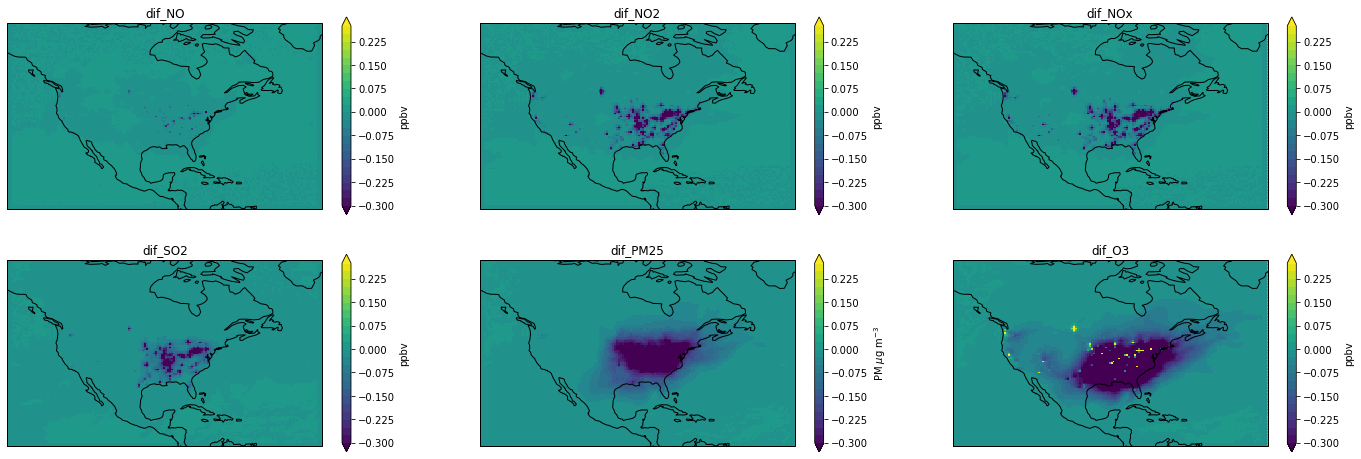

In [17]:
model_plot(dif_names, levels_dif, rows = 2, columns = 3, extension = 'both')

KeyError: 'Parameter Name'

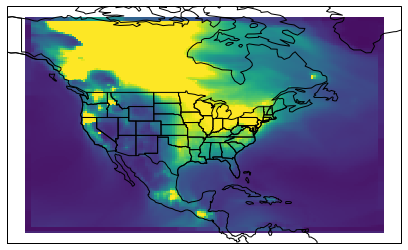

In [18]:
obs_model_plot(species = 'PM25',emis_sources = emis_sources_list,concentration_column = 'Arithmetic Mean', vmin = levels_PM25.min(), vmax = levels_PM25.max(), rows = 1, columns = 3)

In [ ]:
print('max difference in PM '+ str(ds['dif_PM25'].max().values) + ' and min ' + str(ds['dif_PM25'].min().values))
print('max difference in O3 '+ str(ds['dif_O3'].max().values) + ' and min ' + str(ds['dif_O3'].min().values))


In [ ]:
fig = plt.figure(figsize=[24,12])

for idx, s in enumerate(species_names): 
    ax = fig.add_subplot(3,4,idx+1)
    plt.subplots_adjust(hspace = .6)
    plt.plot(ds['time'],ds[f'{s}'].mean(dim=['lat','lon']),'o');
    plt.xlabel('Date')
    plt.ylabel(f'{s} Concentration');
    plt.xticks(rotation=45)
    plt.title(f'{s}')

In [ ]:
plt.plot(ds['time'],ds[f'NEI_NOx'].mean(dim=['lat','lon']),'ro')
spl = UnivariateSpline(Xnew,ds[f'NEI_NOx'].mean(dim=['lat','lon']), s = 0.1)
xs = np.linspace(Xnew.min(), Xnew.max(), 1000)
plt.plot(xs, spl(xs), 'g', lw=3)

In [ ]:
Xnew = matplotlib.dates.date2num(ds['time'])
